In [28]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13908 sha256=32e9ec29d3c83f9e7f790f4e0731f8fcef62564c0e2664f6a48f894eb55f41dd
  Stored in directory: /Users/mcbookairdebat/Library/Caches/pip/wheels/4c/a5/a3/ab48e06c936b39960801612ee2767ff53764119f33d3d646e7
Successfully built utils


In [29]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import scipy.stats as ss
from scipy.stats import norm
import tensorflow as tf 
from tensorflow.keras import layers
import random
import utils

In [3]:
S0,r,sigma,K,T,dt,num_paths,k=100.0, 0.01, 0.2,100.0, 1.0, 1/252, 10000,0
tf.random.set_seed(1)
np.random.seed(1)


In [160]:
def generate_black_scholes_paths(S0=S0, r=r, sigma=sigma, T=T, dt=dt, num_paths=num_paths):
    """
    Generate simulated stock price paths using Black-Scholes model.
    
    :param S0:       Initial stock price
    :param r:        Risk-free rate
    :param sigma:    Volatility
    :param T:        Time horizon (in years)
    :param dt:       Time step (in years)
    :param num_paths: Number of simulated paths
    :return:         Array of shape (num_paths, num_time_steps + 1)
                     containing simulated stock paths
    """
    # Number of time steps
    num_steps = int(T / dt)
    
    # Pre-allocate the array for paths
    # We'll store the entire evolution, so shape is (num_paths, num_steps + 1)
    paths = np.zeros(( num_steps + 1))
    
    # Set initial prices
    paths[0] = S0
    
    # Precompute constants for the Euler-Maruyama update
    # Using log-Euler approach: S_{t+dt} = S_t * exp((r - 0.5 sigma^2) dt + sigma sqrt(dt) * Z)
    drift = (r - 0.5 * sigma ** 2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    # Simulate paths
    for t in range(num_steps):
        # Draw random samples from the standard normal distribution
        Z = np.random.normal(0, 1, num_paths)
        # Update in log-space
        paths[t+1] = paths[t] * np.exp(drift + diffusion * Z)
    
    return paths

In [161]:
paths = generate_black_scholes_paths()
plt.plot(paths.T)

ValueError: setting an array element with a sequence.

In [162]:
def call_option_price(S, K, r, sigma, tau):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

def call_option_delta(S, K, r, sigma, tau):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    return norm.cdf(d1)

In [163]:
option_prices = call_option_price(paths,K=K,r=r,sigma=sigma,tau=dt)
option_delta = call_option_delta(paths,K=K,r=r,sigma=sigma,tau=dt)

In [164]:
import gym
from gym import spaces

In [199]:
class HedgingEnv(gym.Env):
    def __init__(
        self,
        S0=S0,
        K=K,
        r=r,
        sigma=sigma,
        T=T,
        dt=dt,
        kappa =k
    ):
        super(HedgingEnv, self).__init__()
        #HedgingEnv.seed(1)
        #HedgingEnv.action_space.seed(1)
        # Store parameters
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.dt = dt
        self.num_steps = int(T / dt)
        self.kappa = k

        self.action_space = spaces.Discrete(20)
        #self._action_spec = array_spec.BoundedArraySpec(
            #shape=(), dtype=np.int32, minimum=0, maximum=19, name='action')
        # Interpreted as how many units the agent can buy and sell 
        #self.action_space = spaces.Box(
            #low=np.array([-1.0]), 
            #high=np.array([1.0]), 
            #dtype=np.float32
        #)
        self.action_values = np.linspace(-1.0,1,20)
        
        # Observation: (time_index, current_price,current_position)
        # We'll keep it simple: there are all floats, so shape = (4,)
        obs_low  = np.array([0.0,0.0,0.0], dtype=np.float32)
        obs_high = np.array([self.num_steps, 1e9,1.0], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)
        
        # Internal state
        self.reset()



    def reset(self):
        # Generate a single path for this episode
        self.path = generate_black_scholes_paths(S0=self.S0, r=self.r, sigma=self.sigma, T=self.T, dt=self.dt, num_paths=1)
        # Reset time index
        self.t = 0
        # Current price
        self.S = self.path[self.t]
        # Current hedge position; initially zero
        self.position = 0
        # For simplicity, we track the cost of setting up the hedge
        # We'll assume no transaction cost, but you can add it.
        self.cash = 0
        self.done = False
        
        return self._get_obs()
    



    def step(self, action):
        
        new_position = action[0]
        #3.1 Accouting P&L formulation 
        # Ri+1 = Vi+1 −Vi + Hi(Si+1 −Si) −κ|Si+1(Hi+1 −Hi)|

        # Calculate cost to move from old position to new position
        # For simplicity, we treat changes in position as immediate trades at price self.S
        delta_position = new_position - self.position
        cost = self.kappa* np.abs(delta_position * self.S)
        
        tau = (self.num_steps - self.t) * self.dt
        call_px_i = call_option_price(self.S, self.K, self.r, self.sigma, tau)
        stock = self.S
        # Update our "portfolio cash" after trade
        #self.cash -= cost
        
        # Update position
        
        
        # Move to next time step
        self.t += 1
        self.S = self.path[self.t]

        # Computing the different part of the reward 
        #Vi+1 −Vi
        tau = (self.num_steps - self.t) * self.dt
        call_px_i_1 = call_option_price(self.S, self.K, self.r, self.sigma, tau)
        change_call_px = call_px_i_1 - call_px_i
        # Hi(Si+1 −Si)
        change_stock_value = self.position * (self.S - stock)
        #κ|Si+1(Hi+1 −Hi)|
        cost = self.kappa* np.abs(delta_position * self.S)

        self.position = new_position
        done = (self.t == self.num_steps)  # episode ends at maturity

        #if not done:
            #self.S = self.path[self.t]
        
        # Compute reward
        #if done:
            # At maturity, we have an option payoff = max(S-K, 0)
            # Our portfolio is: position * S + cash
            # Hedging error = (option payoff) - (portfolio value)
            #option_payoff = max(self.S - self.K, 0)
            #portfolio_value = self.position * self.S + self.cash  
            #hedging_error = option_payoff - portfolio_value
            
            # Negative of squared error as final reward (for example)
            #reward = - hedging_error
        #else:
            # No immediate reward until maturity in this simple version
        
        reward = change_call_px + change_stock_value - cost
        
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        # Return current time index and current price and current position holding 

        return np.array([self.t, self.S, self.position],dtype=object)


In [200]:


# Actor network: state -> action
class Actor(tf.keras.Model):
    def __init__(self, action_dim=1, max_action=1.0):
        super(Actor, self).__init__()
        self.max_action = max_action
        self.l1 = layers.Dense(128, activation='selu')
        self.l2 = layers.Dense(128, activation='selu')
        self.l3 = layers.Dense(20, activation='selu')
        self.out = layers.Dense(action_dim,activation = 'tanh')  # no activation => raw output
        
    def call(self, state):
        x = self.l1(state)
        x = self.l2(x)
        x = self.l3(x)
        # scale output to [-max_action, max_action]
        raw = self.out(x)
        # For a single action dimension, we can do:
        scaled = self.max_action * tf.tanh(raw)
        return scaled  # shape=(batch_size, 1)

# Critic network: state, action -> Q-value
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.l1 = layers.Dense(128, activation='selu')
        self.l2 = layers.Dense(128, activation='selu')
        self.l3 = layers.Dense(20,activation = 'selu')
        self.out = layers.Dense(1)  # scalar Q-value

    def call(self, state, action):
        # Concatenate [state, action]
        x = tf.concat([state, action], axis=-1)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return self.out(x)


In [201]:


class ReplayBuffer:
    def __init__(self, capacity, state_shape, action_dim=1):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        
        self.states = np.zeros((capacity, state_shape), dtype=np.float32)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.next_states = np.zeros((capacity, state_shape), dtype=np.float32)
        self.dones = np.zeros(capacity, dtype=np.float32)

    def push(self, state, action, reward, next_state, done):
        idx = self.position % self.capacity
        
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = float(done)
        
        self.position += 1
        if len(self.buffer) < self.capacity:
            self.buffer.append(idx)

    def sample(self, batch_size):
        indices = random.sample(self.buffer, batch_size)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return len(self.buffer)


In [202]:
def ddpg_update(
    actor, critic, 
    actor_optimizer, critic_optimizer,
    replay_buffer, 
    batch_size=64, gamma=0.99
):
    # Sample batch
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    
    states_tf = tf.convert_to_tensor(states, dtype=tf.float32)
    actions_tf = tf.convert_to_tensor(actions, dtype=tf.float32)
    rewards_tf = tf.convert_to_tensor(rewards, dtype=tf.float32)
    next_states_tf = tf.convert_to_tensor(next_states, dtype=tf.float32)
    dones_tf = tf.convert_to_tensor(dones, dtype=tf.float32)
    
    # -----------------------
    # 1. Update Critic
    # -----------------------
    with tf.GradientTape() as tape:
        # Current Q(s,a)
        Q_vals = critic(states_tf, actions_tf)

        # Next a' = mu(next_state)
        next_actions = actor(next_states_tf)

        
        # Q(s', a')
        next_Q_vals = critic(next_states_tf, next_actions)
        
        
        # Target y = r + gamma*(1-done)* Q(s', a')
        y = tf.expand_dims(rewards_tf, -1) + gamma * (1.0 - tf.expand_dims(dones_tf, -1)) * next_Q_vals
        
        critic_loss = tf.reduce_mean((y - Q_vals)**2)
        
    
    critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
    
    # -----------------------
    # 2. Update Actor
    # -----------------------
    with tf.GradientTape() as tape:
        # Actor tries to maximize Q(s, mu(s)) => minimize -Q()
        current_actions = actor(states_tf)
        
        actor_loss = -tf.reduce_mean(critic(states_tf, current_actions))
        
    actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
    actor_optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
    
    return critic_loss, actor_loss


In [223]:
def train_ddpg(
    env,
    num_episodes=200,
    max_steps_per_episode=9999,  # or env.num_steps
    buffer_capacity=100000,
    batch_size=64,
    gamma=0.99,
    lr_actor=1e-3,
    lr_critic=1e-3
):
    # Create Actor & Critic
    actor = Actor(action_dim=1, max_action=1)
    critic = Critic()
    
    # Optimizers
    actor_optimizer = tf.keras.optimizers.Adam(lr_actor)
    critic_optimizer = tf.keras.optimizers.Adam(lr_critic)
    
    # Replay buffer
    replay_buffer = ReplayBuffer(capacity=buffer_capacity, state_shape=3, action_dim=1)
    
    # For exploration, we might add noise to the actor's output
    exploration_scale = 0.1
    rewards = []
    for ep in range(num_episodes):
        state = env.reset()
        episode_reward = 0.0
        done = False
        step_count = 0
        
        while not done and step_count < max_steps_per_episode:
            step_count += 1
            
            # Actor forward pass
            state_tf = tf.convert_to_tensor(state.reshape(1, -1), dtype=tf.float32)
            action_tf = actor(state_tf)  # shape (1,1)
            action = action_tf.numpy()[0]  # shape (1,)
            
            # Add noise for exploration
            noise = np.random.normal(0, exploration_scale, size=(1,))
            action_noisy = np.clip(action + noise, -1.0, 1.0)
            
            # Step environment
            next_state, reward, done, _ = env.step(action_noisy)
            
            # Store transition
            replay_buffer.push(state, action_noisy, reward, next_state, done)
            
            state = next_state
            episode_reward += reward
            
            # Train after enough samples
            if len(replay_buffer) > batch_size:
                critic_loss, actor_loss = ddpg_update(
                    actor, critic, 
                    actor_optimizer, critic_optimizer,
                    replay_buffer,
                    batch_size=batch_size,
                    gamma=gamma
                )
        rewards.append(episode_reward)
        print(f"Episode {ep+1}/{num_episodes}: Reward = {episode_reward:.3f}")
    
    return actor, critic, rewards


In [224]:
if __name__ == "__main__":
    env = HedgingEnv(
        S0=100.0,
        K=100.0,
        r=0.01,
        sigma=0.2,
        T=1.0,
        dt=1/252,
    )
    
    actor, critic,rewards = train_ddpg(env, num_episodes=100)
    
    # Test with the (greedy) actor, no noise
    state = env.reset()
    done = False
    total_reward = 0.0
    while not done:
        state_tf = tf.convert_to_tensor(state.reshape(1, -1), dtype=tf.float32)
        action = actor(state_tf).numpy()[0]
        
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
    
    print("Test episode reward:", total_reward)


/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_29731/152808958.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  paths[t+1] = paths[t] * np.exp(drift + diffusion * Z)
/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_29731/3845289238.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


Episode 1/100: Reward = -16.549
Episode 2/100: Reward = 19.995
Episode 3/100: Reward = -1.841
Episode 4/100: Reward = -5.437
Episode 5/100: Reward = -8.854
Episode 6/100: Reward = -1.698
Episode 7/100: Reward = 20.113
Episode 8/100: Reward = -7.910
Episode 9/100: Reward = -5.685
Episode 10/100: Reward = -5.851
Episode 11/100: Reward = -4.540
Episode 12/100: Reward = -8.462
Episode 13/100: Reward = -8.030
Episode 14/100: Reward = -3.979
Episode 15/100: Reward = 0.879
Episode 16/100: Reward = 12.811
Episode 17/100: Reward = -1.081
Episode 18/100: Reward = -5.971
Episode 19/100: Reward = -3.940
Episode 20/100: Reward = -5.026
Episode 21/100: Reward = 9.330
Episode 22/100: Reward = -0.656
Episode 23/100: Reward = 9.587
Episode 24/100: Reward = -7.834
Episode 25/100: Reward = -3.945
Episode 26/100: Reward = 7.246
Episode 27/100: Reward = -9.282
Episode 28/100: Reward = -2.683
Episode 29/100: Reward = 4.871
Episode 30/100: Reward = -5.188
Episode 31/100: Reward = 10.799
Episode 32/100: Rewar

(array([ 1.,  0.,  2.,  6., 16., 15., 11.,  4., 12.,  6.,  3.,  6.,  4.,
         3.,  6.,  0.,  1.,  1.,  0.,  3.]),
 array([-16.54933998, -14.71619823, -12.88305649, -11.04991474,
         -9.21677299,  -7.38363125,  -5.5504895 ,  -3.71734775,
         -1.88420601,  -0.05106426,   1.78207749,   3.61521923,
          5.44836098,   7.28150273,   9.11464447,  10.94778622,
         12.78092797,  14.61406971,  16.44721146,  18.28035321,
         20.11349495]),
 <BarContainer object of 20 artists>)

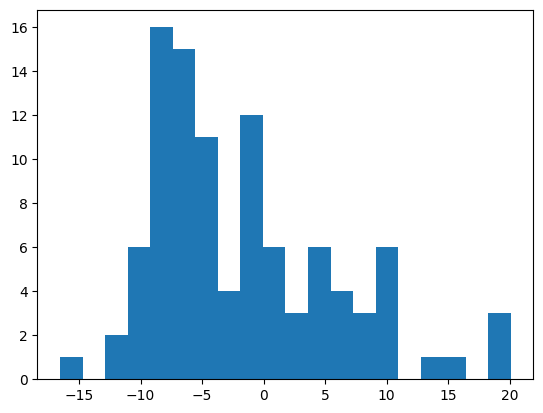

In [229]:
plt.hist(rewards,bins =20)

In [81]:
class QNetwork(tf.keras.Model):
    def __init__(self, num_actions):
        super(QNetwork, self).__init__()
        self.dense1 = layers.Dense(50, activation='selu')
        self.dense2 = layers.Dense(50, activation='selu')
        self.dense3 = layers.Dense(20, activation='selu')
        self.out = layers.Dense(num_actions)  # No activation, raw Q-values

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.out(x)

In [78]:
if __name__ == "__main__":
    env = HedgingEnv()
    obs = env.reset()
    done = False
    total_reward = 0.0
    
    while not done:
        # Random action
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        total_reward += reward
    
    print("Episode finished. Total reward:", total_reward)
    print("Final observation:", obs)

Episode finished. Total reward: [-2976542.84133029]
Final observation: [252 np.float64(138.65904705679307) np.float64(38.65904705679307)
 np.float64(1.0)]


/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_29731/152808958.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  paths[t+1] = paths[t] * np.exp(drift + diffusion * Z)
/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_29731/3845289238.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_29731/3845289238.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


In [2]:
def shuffle_batch(X, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idx]
        yield X_batch


In [5]:
def reset_graph():
    tf.compat.v1.reset_default_graph()

def set_seed(seed=42):
    tf.compat.v1.set_random_seed(seed)
    np.random.seed(seed)

In [6]:
reset_graph()
retraining = False
exponential_learning_rate_decay = False

In [8]:
## Creating checkpoints
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tflogs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [9]:
## network architecture 
# Time series and network parameters
n_steps = 52  # length of a time series
n_inputs = 2  # dimensionality of input
n_neurons = [50, 50, 20, 2]  # number of nodes in each layer
activations = [tf.nn.selu, tf.nn.selu, tf.nn.selu, None]  # activation functions
n_layers = 4

In [10]:
# Setting up performance scheduling
max_checks_without_progress = 10
checks_without_progress = 0
if not retraining:
    best_loss = np.inf


In [11]:
# (Optional) decay parameters for exponential decay
# decay_steps = 4000  
# decay_rate = 1/3

In [12]:
# Training parameters
initial_learning_rate = 0.00005
n_epochs = 400
global_step = tf.Variable(0, trainable=False, name="global_step")
batch_size = 200

In [24]:
# Build the model using the Keras Functional API
inputs = tf.keras.Input(shape=(n_steps, n_inputs))
# Example RNN layers
layer = tf.keras.layers.SimpleRNN(n_neurons[0], activations[0], return_sequences=True)(inputs)
layer = tf.keras.layers.SimpleRNN(n_neurons[1], activations[1], return_sequences=True)(layer)
layer = tf.keras.layers.SimpleRNN(n_neurons[2], activations[2], return_sequences=True)(layer)
outputs = tf.keras.layers.SimpleRNN(n_neurons[3], activations[3], return_sequences=False)(layer)

# Create a Keras model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [25]:
# Setting up performance scheduling
max_checks_without_progress = 10
checks_without_progress = 0
if not retraining:
    best_loss = np.inf

# (Optional) decay parameters for exponential decay
# decay_steps = 4000  
# decay_rate = 1/3

# Training parameters
initial_learning_rate = 0.00005
n_epochs = 400
global_step = tf.Variable(0, trainable=False, name="global_step")
batch_size = 200

In [26]:
# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(100.0, 0.5),             
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
)


In [27]:

# Print model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 52, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 52, 50)         │         2,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 52, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 52, 20)         │         1,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 2)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,166 (35.80 KB)

 Trainable params: 9,166 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Variables initializer and Saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [ ]:
# Custom training loop
for epoch in range(n_epochs):
    # 1) Training step
    for X_batch, Y_batch in shuffle_batch(X_train, Y_train, batch_size):
        with tf.GradientTape() as tape:
            predictions = model(X_batch, training=True)
            batch_loss = loss_fn(Y_batch, predictions)
        grads = tape.gradient(batch_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # 2) Compute losses for entire training & validation sets
    #    (In practice, you might do this in mini-batches if large.)
    train_predictions = model(X_train, training=False)
    loss_train = loss_fn(Y_train, train_predictions).numpy()

    val_predictions = model(X_validation, training=False)
    loss_val = loss_fn(Y_validation, val_predictions).numpy()

    # 3) Performance scheduling (similar logic to your old code)
    if not exponential_learning_rate_decay:
        # If current validation is better than the best so far
        if loss_val < best_loss:
            # Save the model
            model.save("./my_dissertation_model.h5")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1

        # Early stopping
        if checks_without_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    # 4) Print progress
    # If you had an LR schedule, you'd do something like:
    # current_lr = optimizer.learning_rate(current_step).numpy() if callable(optimizer.learning_rate) else optimizer.learning_rate
    # For a static LR:
    current_lr = optimizer.learning_rate.numpy() if hasattr(optimizer.learning_rate, 'numpy') else optimizer.learning_rate

    if exponential_learning_rate_decay:
        # mimic your old print with .eval() — in TF2, we can .numpy()
        print(f"{epoch}\tCurrent train loss: {loss_train:.6f}\tCurrent val loss: {loss_val:.6f}\t"
              f"Best loss: {best_loss:.6f}\tLearning rate: {current_lr:.6f}")
    else:
        print(f"{epoch}\tCurrent train loss: {loss_train:.6f}\tCurrent val loss: {loss_val:.6f}\t"
              f"Best loss: {best_loss:.6f}\tLearning rate: {current_lr:.10f}")


In [ ]:
# Saving final results
with tf.Session() as sess:
    saver.restore(sess, "./my dissertation model.ckpt")
    print("Final loss: {:.6f}".format(best_loss))

    outputs_validation = sess.run(outputs, feed_dict={X: X_validation})
    outputs_train = sess.run(outputs, feed_dict={X: X_train})
    outputs_test = sess.run(outputs, feed_dict={X: X_test})

    loss_validation = sess.run(loss, feed_dict={X: X_validation})
    loss_train = sess.run(loss, feed_dict={X: X_train})
    loss_test = sess.run(loss, feed_dict={X: X_test})

In [19]:
import tensorflow as tf
import numpy as np

# -------------------------
# 1) Hyperparameters
# -------------------------
n_steps = 52   # length of a time series
n_inputs = 2   # dimensionality of input
n_neurons = [50, 50, 20, 2]  # number of nodes in each layer
activations = [tf.nn.selu, tf.nn.selu, tf.nn.selu, None]  # activation functions
n_layers = 4

# Performance scheduling
max_checks_without_progress = 10
checks_without_progress = 0
retraining = False  # Suppose we define this somewhere
best_loss = np.inf

# (Optional) Exponential decay parameters
exponential_learning_rate_decay = False  # toggle it as needed
decay_steps = 4000
decay_rate = 1/3

# Training parameters
initial_learning_rate = 0.00005
n_epochs = 400
batch_size = 200

# -------------------------
# 2) Define a custom entropic loss (placeholder implementation)
#    Replace with your actual entropic logic if you have it.
# -------------------------
def entropic_loss(alpha=100.0, beta=0.5):
    """
    A placeholder for the custom entropic loss from your original code.
    Modify this function as per your real formula.
    """
    def loss_fn(y_true, y_pred):
        # Example dummy formula for demonstration:
        #  (Not actually "entropic", just for structure)
        return alpha * tf.reduce_mean(tf.abs(y_true - y_pred)) + beta
    return loss_fn

# -------------------------
# 3) Build the Model using tf.keras
# -------------------------
# Instead of placeholders, we define an Input layer describing the shape:
inputs = tf.keras.Input(shape=(n_steps, n_inputs))

# Create multiple RNN cells with the specified activations:
# If you strictly want "BasicRNNCell" behavior from TF1.x, you can use "SimpleRNNCell" in TF2.
rnn_cells = []
for i in range(n_layers):
    units = n_neurons[i]
    activation = activations[i]
    # We'll use SimpleRNNCell to mimic BasicRNNCell
    rnn_cells.append(tf.keras.layers.SimpleRNNCell(units=units, activation=activation))

# Stack them in a single RNN layer:
# return_sequences=True to pass output from each time step,
# return_state=False unless you specifically need final states.
rnn_layer = tf.keras.layers.RNN(rnn_cells, return_sequences=True, return_state=False)

# Get the outputs
outputs = rnn_layer(inputs)

# Create a Keras Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# -------------------------
# 4) Set up the (optional) learning-rate schedule
# -------------------------
if exponential_learning_rate_decay:
    # If you want actual dynamic decay, use a schedules.ExponentialDecay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=False  # or True depending on your preference
    )
    current_lr = lr_schedule
else:
    current_lr = initial_learning_rate

# -------------------------
# 5) Compile the model with Adam and the custom entropic loss
# -------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=current_lr),
    loss=entropic_loss(100.0, 0.5)
)

# Just a quick check
model.summary()

# -------------------------
# 6) Example dummy training loop (if you have data)
# -------------------------
# Suppose X_train is shape (num_samples, n_steps, n_inputs)
# and y_train is shape (num_samples, n_steps, 2) or something that matches outputs:
# 
# X_train = np.random.randn(1000, n_steps, n_inputs).astype(np.float32)
# y_train = np.random.randn(1000, n_steps, 2).astype(np.float32)
# 
# model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)

print("Up and running with TensorFlow 2.x!")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 52, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ (None, 52, 2)          │         9,166 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,166 (35.80 KB)

 Trainable params: 9,166 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

Up and running with TensorFlow 2.x!
